## Access this Notebook
You can launch this notebook in the US GHG Center JupyterHub by clicking the link below. If you are a new user, you should first sign up for the hub by filling out this [**request form**](https://docs.google.com/forms/d/e/1FAIpQLSdai8otCdrVQzJgev8mjDhzKyCg7jcrB3UeTXNHoCiaMKrkaQ/viewform) and providing the required information. 


Access the [**OCO-2 GEOS Column CO₂ Concentrations**](https://us-ghg-center.github.io/ghgc-docs/user_data_notebooks/oco2geos-co2-daygrid-v10r_User_Notebook.html) notebook in the US GHG Center JupyterHub. 

## Table of Contents
- [Data Summary and Application](#data-summary-and-application)
- [Approach](#approach)
- [About the Data](#about-the-data)
- [Install the Required Libraries](#install-the-required-libraries)
- [Query the STAC API](#query-the-stac-api)
- [Visual Comparison Across Time Periods](#visual-comparison-across-time-periods)
- [Map Out Selected Tiles](#map-out-selected-tiles)
- [Calculate Zonal Statistics](#calculate-zonal-statistics)
- [Time-Series Analysis](#time-series-analysis)
- [Summary](#summary)

## Data Summary and Application
- **Spatial coverage**: Global
- **Spatial resolution**: 0.5° x 0.625°
- **Temporal extent**: January 1, 2015 - February 28, 2022
- **Temporal resolution**: Daily
- **Unit**: Parts per million
- **Utility**: Climate Research

For more, visit the [OCO-2 GEOS Column CO₂ Concentrations](https://earth.gov/ghgcenter/data-catalog/oco2geos-co2-daygrid-v10r) data overview page.  

## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the OCO-2 GEOS Column CO₂ Concentrations data product.
2. Pass the STAC item into the raster API `/collections/{collection_id}/items/{item_id}/tilejson.json` endpoint.
3. Using `folium.plugins.DualMap`, visualize two tiles (side-by-side), allowing time point comparison.
4. After the visualization, perform zonal statistics for a given polygon.

   

## About the Data

In July 2014, NASA successfully launched the first dedicated Earth remote sensing satellite to study atmospheric carbon dioxide (CO₂) from space. The Orbiting Carbon Observatory-2 (OCO-2) is an exploratory science mission designed to collect space-based global measurements of atmospheric CO₂ with the precision, resolution, and coverage needed to characterize sources and sinks (fluxes) on regional scales (≥1000 km). This dataset provides global gridded, daily column-averaged carbon dioxide (XCO₂) concentrations from January 1, 2015 - February 28, 2022. The data are derived from OCO-2 observations that were input to the Goddard Earth Observing System (GEOS) Constituent Data Assimilation System (CoDAS), a modeling and data assimilation system maintained by NASA’s Global Modeling and Assimilation Office (GMAO). Concentrations are measured in moles of carbon dioxide per mole of dry air (mol CO₂/mol dry) at a spatial resolution of 0.5° x 0.625°. Data assimilation synthesizes simulations and observations, adjusting modeled atmospheric constituents like CO₂ to reflect observed values. With the support of NASA’s Carbon Monitoring System (CMS) Program and the OCO Science Team, this dataset was produced as part of the OCO-2 mission which provides the highest quality space-based XCO₂ retrievals to date.

For more information regarding this dataset, please visit the [OCO-2 GEOS Column CO₂ Concentrations](https://earth.gov/ghgcenter/data-catalog/oco2geos-co2-daygrid-v10r) data overview page.

## Install the Required Libraries
Required libraries are pre-installed on the GHG Center Hub. If you need to run this notebook elsewhere, please install them with this line in a code cell:

%pip install requests folium rasterstats pystac_client pandas matplotlib --quiet

In [1]:
# Import the following libraries
import requests
import folium
import folium.plugins
from folium import Map, TileLayer
from pystac_client import Client
import branca
import pandas as pd
import matplotlib.pyplot as plt
from stats_module import generate_stats, clean_stats, display_stats

## Query the STAC API
First, we are going to import the required libraries. Once imported, they allow better executing a query in the GHG Center Spatio Temporal Asset Catalog (STAC) Application Programming Interface (API) where the granules for this collection are stored.

In [2]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# Please use the collection name similar to the one used in STAC collection.
# Name of the collection for OCO-2 GEOS Column CO₂ Concentrations. 
collection_name = "oco2geos-co2-daygrid-v10r"

Examining the contents of our `collection` under the `temporal` variable, we see that the data is available from January 2015 to February 2022. By looking at the `dashboard:time density`, we can see that these observations are collected daily.

In [3]:
# Using PySTAC client
# Fetch the collection from the STAC API using the appropriate endpoint
# The 'pystac' library allows a HTTP request possible
catalog = Client.open(STAC_API_URL)
collection = catalog.get_collection(collection_name)

# Print the properties of the collection to the console
collection

<CollectionClient id=oco2geos-co2-daygrid-v10r>

In [4]:
# Check total number of items available
items = list(collection.get_items())  # Convert the iterator to a list
print(f"Found {len(items)} items")

Found 2615 items


In [5]:
# Examining the first item in the collection
items[0]

<Item id=oco2geos-co2-daygrid-v10r-20220228>

Below, we enter minimum and maximum values to provide our upper and lower bounds in `rescale_values`.

## Visual Comparison Across Time Periods

In this notebook, we will explore the temporal impacts of CO₂ emissions. We will visualize the outputs on a map using `folium.`

In [6]:
# Now we create a dictionary where the start datetime values for each granule is queried more explicitly by year and month (e.g., 2020-02)
# To access the year value from each item more easily, this will let us query more explicitly by year and month (e.g., 2020-02)
items = {item.properties["datetime"][:10]: item for item in collection.get_items()}

asset_name = "xco2" #fossil fuel

Now, we will pass the item id, collection name, and `rescaling_factor` to the `Raster API` endpoint. We will do this twice, once for 2022-02-08 and again for 2022-01-27, so that we can visualize each event independently.

In [7]:
# Choose a color for displaying the tiles
# Please refer to matplotlib library if you'd prefer choosing a different color ramp.
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html
color_map = "magma" 

# Make a GET request to retrieve information for the date mentioned below
first_date = items["2019-04-25"]

# Extract collection name and item ID
collection_id = first_date.collection_id
item_id = first_date.id

object = first_date.assets[asset_name]
raster_bands = object.extra_fields.get("raster:bands", [{}])
rescale_values = {
    "max": raster_bands[0].get("histogram", {}).get("max"),
    "min": raster_bands[0].get("histogram", {}).get("min"),
}

print(rescale_values)

{'max': 417.44707777979784, 'min': 404.69744271831587}


In [8]:
# Make a GET request to retrieve information for the date mentioned below
month1_tile = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale=412,422"
).json()

# Print the properties of the retrieved granule to the console
month1_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/oco2geos-co2-daygrid-v10r/items/oco2geos-co2-daygrid-v10r-20190425/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=xco2&color_formula=gamma+r+1.05&colormap_name=magma&rescale=412%2C422'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.3125, -90.25, 179.6875, 90.25],
 'center': [-0.3125, 0.0, 0]}

In [9]:
# Make a GET request to retrieve information for date mentioned below
second_date = items["2021-04-25"]

# Extract collection name and item ID
collection_id = second_date.collection_id
item_id = second_date.id

object = second_date.assets[asset_name]
raster_bands = object.extra_fields.get("raster:bands", [{}])
rescale_values = {
    "max": raster_bands[0].get("histogram", {}).get("max"),
    "min": raster_bands[0].get("histogram", {}).get("min"),
}

print(rescale_values)

month2_tile = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale=412,422"
).json()

# Print the properties of the retrieved granule to the console
month2_tile

{'max': 422.8104808134958, 'min': 409.4469404662959}


{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/oco2geos-co2-daygrid-v10r/items/oco2geos-co2-daygrid-v10r-20210425/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=xco2&color_formula=gamma+r+1.05&colormap_name=magma&rescale=412%2C422'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.3125, -90.25, 179.6875, 90.25],
 'center': [-0.3125, 0.0, 0]}

## Map Out Selected Tiles

In [10]:
# To change the location, you can simply insert the latitude and longitude of the area of your interest in the "location=(LAT, LONG)" statement

# Set the initial zoom level and center of map for both tiles
# 'folium.plugins' allows mapping side-by-side
map_ = folium.plugins.DualMap(location=(34, -118), zoom_start=3)

# Define the first map layer (January 2020)
map_layer_2020 = TileLayer(
    tiles=month1_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.8, # Adjust the transparency of the layer
)

# Add the first layer to the Dual Map
map_layer_2020.add_to(map_.m1)

# Define the second map layer (January 2000)
map_layer_2000 = TileLayer(
    tiles=month2_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.8, # Adjust the transparency of the layer
)

# Add the second layer to the Dual Map
map_layer_2000.add_to(map_.m2)

# Visualize the Dual Map
map_

## Calculating Zonal Statistics

To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon in Texas (USA).

In [11]:
# Create a polygon for the area of interest (aoi)
sanfrancisco_aoi = {
    "type": "Feature", # Create a feature object
    "properties": {},
    "geometry": { # Set the bounding coordinates for the polygon
        "coordinates": [
            [
                [-122.52709933248232, 37.816224913955665],
                [-122.52709933248232,37.69714432421999],
                [-122.3493837208909,37.69714432421999],
                [-122.3493837208909,37.816224913955665],
                [-122.52709933248232,37.816224913955665]            
            ]
        ],
        "type": "Polygon",
    },
}

In [12]:
# Check total number of items available
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=600"
).json()["features"]
print(f"Found {len(items)} items")

Found 600 items


In [22]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
def generate_stats(item, geojson):
    result = requests.post(
        f"{RASTER_API_URL}/cog/statistics",
        params={"url": item["assets"][asset_name]["href"]},
        json=geojson,
    ).json()
    print(result)
    return {
        **result["properties"],
        "datetime": item["properties"]["datetime"],
    }

In [23]:
for item in items:
    print(item["properties"]["datetime"])
    break

2022-02-28T00:00:00+00:00


With the function above we can generate the statistics for the AOI.

In [ ]:
%%time
stats = [generate_stats(item, sanfrancisco_aoi) for item in items]

In [25]:
stats[0]

{'statistics': {'b1': {'min': 419.244261138374,
   'max': 419.24496690626256,
   'mean': 419.2446140223183,
   'count': 0.1599999964237213,
   'sum': 67.07913674423534,
   'std': 0.00035288394428789616,
   'median': 419.244261138374,
   'majority': 419.244261138374,
   'minority': 419.244261138374,
   'unique': 2.0,
   'histogram': [[1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [419.244261138374,
     419.24433171516284,
     419.2444022919517,
     419.24447286874056,
     419.2445434455294,
     419.2446140223183,
     419.24468459910713,
     419.244755175896,
     419.24482575268485,
     419.2448963294737,
     419.24496690626256]],
   'valid_percent': 100.0,
   'masked_pixels': 0.0,
   'valid_pixels': 2.0,
   'percentile_2': 419.244261138374,
   'percentile_98': 419.24496690626256}},
 'datetime': '2022-02-28T00:00:00+00:00'}

In [26]:
df = clean_stats(stats)
df.head(5)

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2022-02-28T00:00:00+00:00,419.244261,419.244967,419.244614,0.16,67.079137,0.000353,419.244261,419.244261,419.244261,2.0,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 1], [419.24426113...",100.0,0.0,2.0,419.244261,419.244967,2022-02-28 00:00:00+00:00
1,2022-02-27T00:00:00+00:00,419.349079,419.429227,419.389153,0.16,67.102263,0.040074,419.349079,419.349079,419.349079,2.0,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 1], [419.34907858...",100.0,0.0,2.0,419.349079,419.429227,2022-02-27 00:00:00+00:00
2,2022-02-26T00:00:00+00:00,419.398257,419.405147,419.401702,0.16,67.104271,0.003445,419.398257,419.398257,419.398257,2.0,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 1], [419.39825678...",100.0,0.0,2.0,419.398257,419.405147,2022-02-26 00:00:00+00:00
3,2022-02-25T00:00:00+00:00,419.067321,419.279710,419.173515,0.16,67.067761,0.106194,419.067321,419.067321,419.067321,2.0,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 1], [419.06732076...",100.0,0.0,2.0,419.067321,419.279710,2022-02-25 00:00:00+00:00
4,2022-02-24T00:00:00+00:00,419.393054,419.461197,419.427126,0.16,67.108339,0.034071,419.393054,419.393054,419.393054,2.0,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 1], [419.39305447...",100.0,0.0,2.0,419.393054,419.461197,2022-02-24 00:00:00+00:00


## Time-Series Analysis
We can now explore the XCO₂ concentrations time series (January 1, 2015 - February 28, 2022) available for the Dallas, Texas area of the U.S. We can plot the data set using the code below:

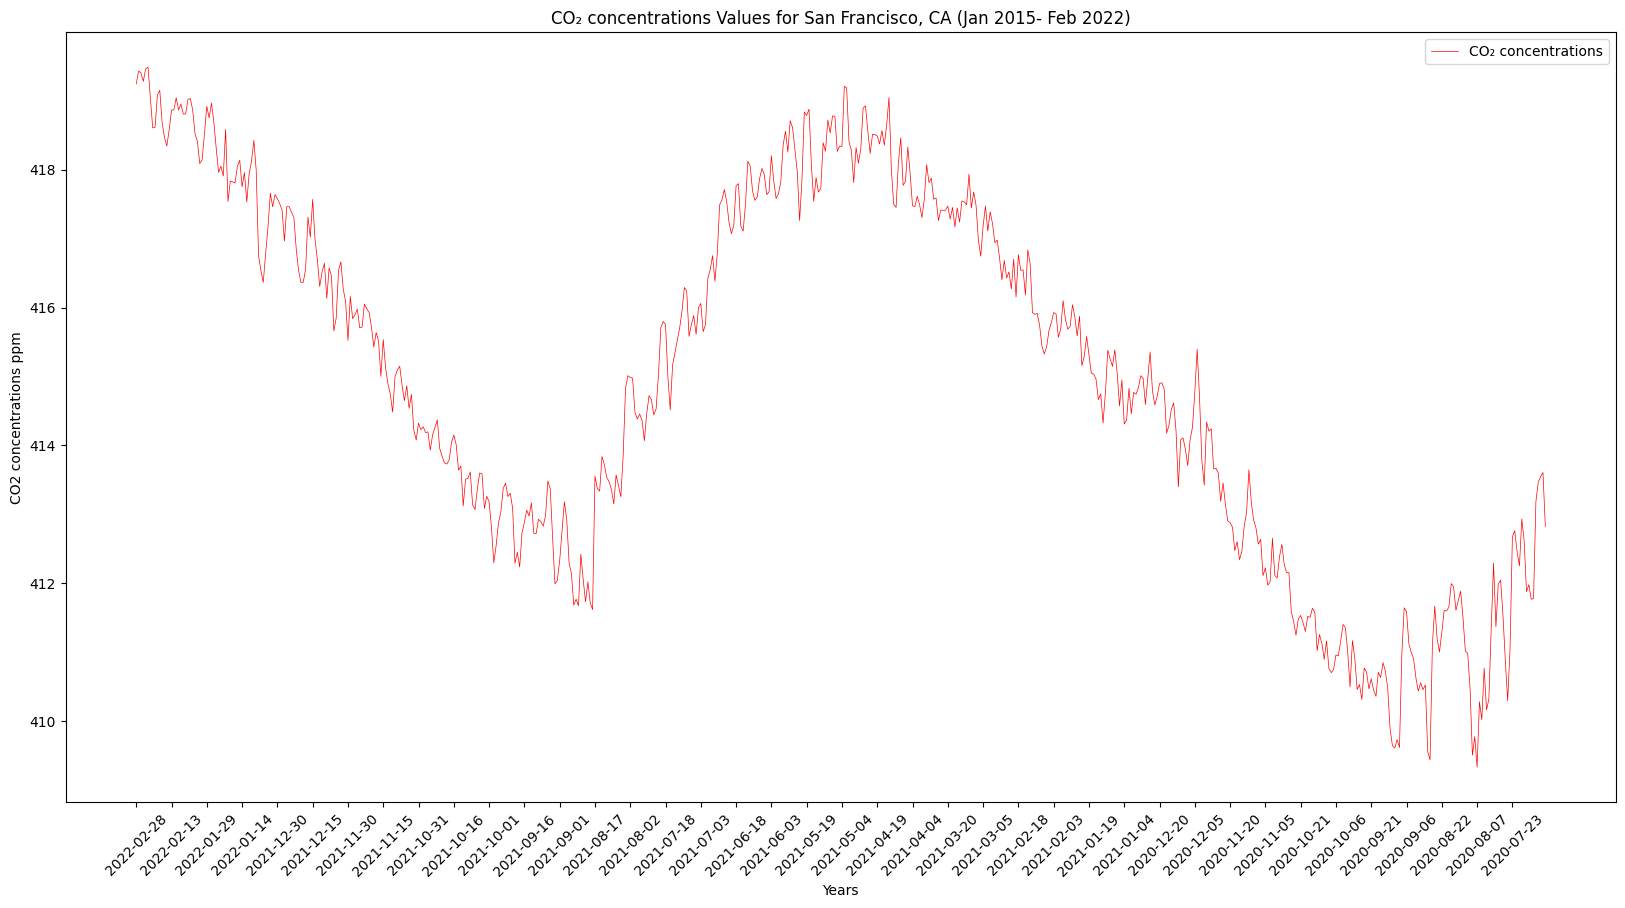

In [27]:
fig = plt.figure(figsize=(20, 10))


plt.plot(
    df["datetime"],
    df["max"],
    color="red",
    linestyle="-",
    linewidth=0.5,
    label="CO₂ concentrations",
)

plt.legend()
plt.xlabel("Years")
plt.ylabel("CO2 concentrations ppm")
plt.title("CO₂ concentrations Values for San Francisco, CA (Jan 2015- Feb 2022)")

x_labels = [str(label)[:10] for label in df["datetime"][::15]]
plt.xticks(df["datetime"][::15], labels=x_labels, rotation=45)

# Plot the time series
plt.show()

## Summary

In this notebook, we have successfully explored, analyzed, and visualized the STAC collection for OCO-2 GEOS Column CO₂ Concentrations.

1.  Install and import the necessary libraries
2.  Fetch the collection from STAC collections using the appropriate endpoints
3.  Count the number of existing granules within the collection
4.  Map and compare the Column-Averaged XCO₂ Concentrations Levels for two distinctive months/years
5.  Generate zonal statistics for the area of interest (AOI)
6.  Visualizing the Data as a Time Series


If you have any questions regarding this user notebook, please contact us using the [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSeVWCrnca08Gt_qoWYjTo6gnj1BEGL4NCUC9VEiQnXA02gzVQ/viewform).